# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Object Detection. </center>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [2]:
import xmltodict, json

In [3]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, one_class=False):
        self.images = []
        self.annotations = []
        self.transform = None
        self.one = one_class
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            if self.one:
                labels = self.annotations[i]["labels"]
                labels = torch.tensor([1] * len(labels))
                self.annotations[i]["labels"] = labels
                
            return self.images[i], self.annotations[i]
                

    def __len__(self):
        return len(self.images)

In [4]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

<br>  
<br>  
  
## Часть 1.  
  
*Вес в общей оценке - 0.4*  
  
В данной части вам нужно решить задачу детектирования фруктов "без классификации". Для этого все три класса нужно объединить в один (нужно внести соотвествующие изменения в датасет).

In [5]:
import torchvision 
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

from torchvision.models.detection import _utils as det_utils

from torchvision import models
from torchvision.models import detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import os, sys, glob
import cv2
import copy
from tqdm import tqdm

from matplotlib import pyplot as plt

train, test = r"train_zip/train/", "test_zip/test/"

In [9]:
train_dataset = FruitDataset(train, one_class=True)

In [10]:
example = next(iter(train_dataset))

tensor([1])


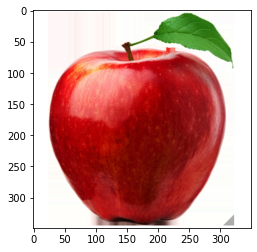

In [11]:
plt.imshow(example[0])
print(example[1]["labels"])

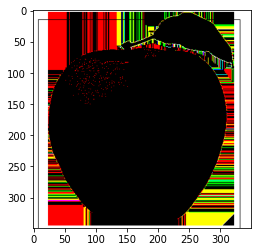

In [12]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as tt

tens = tt.ToTensor()
nump = tt.ToPILImage()


def to_numpy(tensor):
    tensor = tensor.to(torch.device("cpu")).detach().numpy()
    tensor*=255
    tensor = np.moveaxis(tensor, 0, 2)
    return tensor

def to_tensor(img):
    img = img.astype(np.float32)
    img = img / 255
    img = np.moveaxis(img, 2, 0)
    img = torch.from_numpy(img)
    return img


img = to_tensor(example[0]).type(torch.uint8)
img_with_boxes = draw_bounding_boxes(img, example[1]["boxes"], colors=(0, 255, 0))

img = to_numpy(img_with_boxes)
plt.imshow(img)

Что-то с форматом цвета. Я пробовал исправить, но ни одно преобразование не помогает. Общая картина понятна, поэтому ок.

### Задание 1.  
  
Примените обученные детекторы из [torchvision.models](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) - Faster R-CNN, RetinaNet, SSD (можно только с одним backbone, можно все попробовать) - и оцените качество детекции на тестовом датасете. 

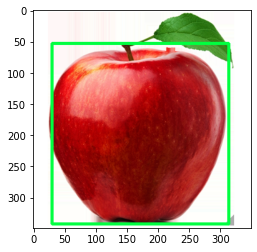

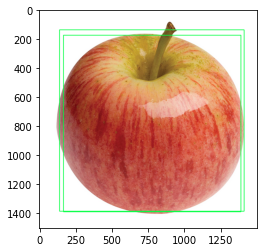

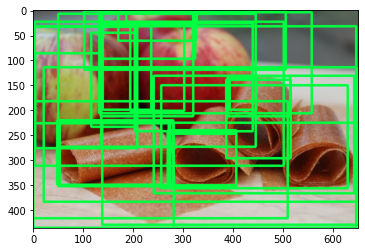

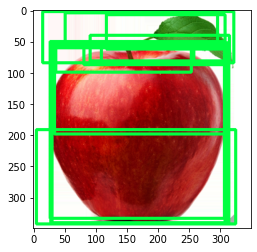

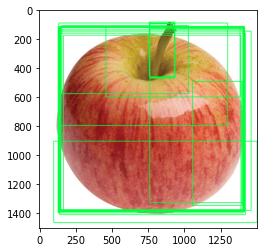

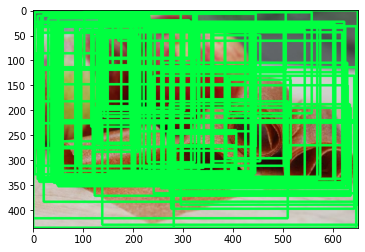

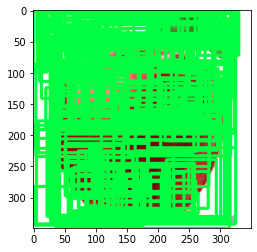

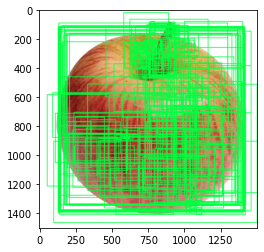

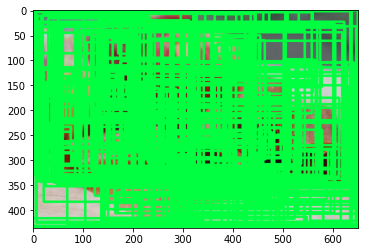

In [13]:
def create_boxes(img, boxes):
    for b in boxes:
        cv2.rectangle(img, (int(b[0].item()), int(b[1].item())), 
                     (int(b[2].item()), int(b[3].item())), (0, 255, 64), 3)
        
    plt.figure()
    plt.imshow(img)


def predict(model, dataset):
    
    max_x = 3
    
    for i, x in enumerate(dataset):
        if i == max_x:
            break
        model.eval()
        x = copy.copy(x)
        pred = model([to_tensor(x[0])])
        img = to_tensor(copy.copy(x[0])).type(torch.uint8)
        boxes = pred[0]["boxes"]
        create_boxes(x[0], boxes)
        
fasterrcnn = detection.fasterrcnn_resnet50_fpn(pretrained=True)
retinanet = detection.retinanet_resnet50_fpn(pretrained=True)
ssdvgg16 = detection.ssd300_vgg16(pretrained=True)

predict(fasterrcnn, train_dataset)
predict(retinanet, train_dataset)
predict(ssdvgg16, train_dataset)

Точность хорошая, за исключением SSD, но рисуется много лишнего, после обучения добавим отсеивание по score. Теперь дообучим классификатор сети Faster RCNN. Также попробуем дообучить box regressor, и выберем лучший вариант 

### Задание 2.  
  
Обучите детекторы из задания выше на обучающем датасете, оцените качество на тестовом. При необходимости, подберите гиперпараметры - optimizer, lr, weight_decay etc.  
Выполните обучение в двух вариантах: со случайной инициализацией весов и с загрузкой весов уже обученной модели. Сравните качество. 

In [18]:
def fit(model, ep, opt, dataloader):
    
    
    stats = []
    
    model.train()
    model = model.to(dev)
    
    for e in range(ep):
        
        loss_epoch = []
        
        for batch in tqdm(dataloader):
            imgs = [to_tensor(x).to(dev) for x in batch[0]]
            lab = [{a:b.to(dev) for a, b in x.items()} for x in batch[1]]
            
            opt.zero_grad()
            all_loses = model(imgs, lab)
            real_loss = np.sum(x for x in all_loses.values())
            real_loss.backward()
            opt.step()
            
            loss_epoch.append(real_loss.item())
            
        loss = np.mean(loss_epoch)
        print(f"epoch number {e+1}, loss is {loss}\n"+"="*30)
        
        stats.append(loss)
    
    return stats
            
            
            

In [19]:
model1 = detection.fasterrcnn_resnet50_fpn(pretrained=True)
model2 = detection.fasterrcnn_resnet50_fpn(pretrained=False)

model1.backbone.requires_grad = False
model1.rpn.requires_grad = False

in_features = model2.roi_heads.box_predictor.cls_score.in_features
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2) 

In [20]:
optim1 = torch.optim.SGD(model1.parameters(), lr=1e-4)
optim2 = torch.optim.SGD(model2.parameters(), lr=5e-3)

train_dataloader = DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)

In [21]:
stats1 = fit(model1, 5, optim1, train_dataloader)

torch.save(model1.state_dict(), "model1.pth")

100%|█████████████████████████████████████████████████████████████████| 240/240 [01:28<00:00,  2.71it/s]


epoch number 1, loss is 0.5166028167586774


100%|█████████████████████████████████████████████████████████████████| 240/240 [01:10<00:00,  3.39it/s]


epoch number 2, loss is 0.23166416020443042


100%|█████████████████████████████████████████████████████████████████| 240/240 [01:13<00:00,  3.26it/s]


epoch number 3, loss is 0.21058076184708624


100%|█████████████████████████████████████████████████████████████████| 240/240 [01:12<00:00,  3.31it/s]


epoch number 4, loss is 0.19965929740574212


100%|█████████████████████████████████████████████████████████████████| 240/240 [01:12<00:00,  3.30it/s]


epoch number 5, loss is 0.1945755243068561


In [22]:
stats2 = fit(model2, 5, optim2, train_dataloader)

torch.save(model2.state_dict(), "model2.pth")

100%|█████████████████████████████████████████████████████████████████| 240/240 [01:10<00:00,  3.41it/s]


epoch number 1, loss is 0.3686511700352033


100%|█████████████████████████████████████████████████████████████████| 240/240 [01:11<00:00,  3.35it/s]


epoch number 2, loss is 0.2686595799556623


100%|█████████████████████████████████████████████████████████████████| 240/240 [01:11<00:00,  3.35it/s]


epoch number 3, loss is 0.24159767421272893


100%|█████████████████████████████████████████████████████████████████| 240/240 [01:12<00:00,  3.33it/s]


epoch number 4, loss is 0.22677958086133004


100%|█████████████████████████████████████████████████████████████████| 240/240 [01:11<00:00,  3.35it/s]


epoch number 5, loss is 0.21827342428732663


### Задание 3.  
  
- Для лучшей модели оцените, как меняется качество на тестовых данных при изменении порога IoU.  
- Также добавьте порог для минимального значения score у предсказанных bounding box'ов, таким образом отсеивая предсказания с низким конфиденсом. Оцените, как меняется качество при изменении порога (порог IoU используйте 0.5). 

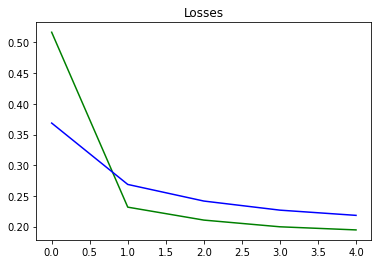

In [23]:
plt.plot(stats1, color='green')
plt.plot(stats2, color='blue')
plt.title("Losses")
plt.show()

### Задание 4.  
  
Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета и каких-нибудь картинок из __интернета__ (релевантных - где есть эти фрукты - и тех, где этих фруктов нет).

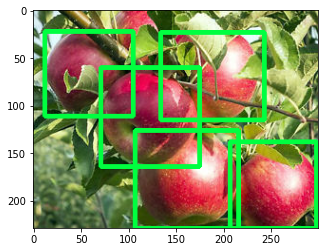

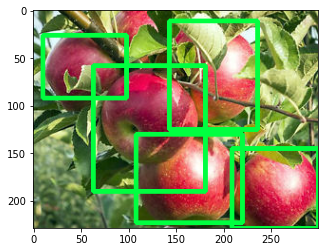

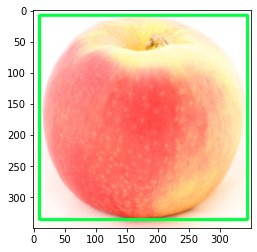

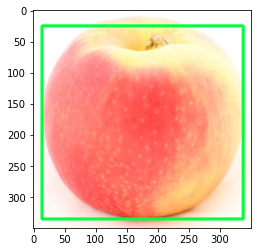

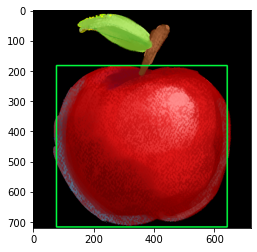

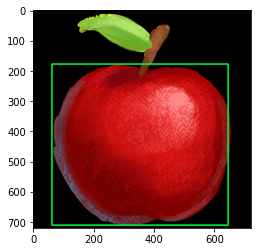

In [29]:
dev = torch.device("cpu")

def create_boxes_advances(img, boxes, scores, T=0.5):
    for b, s in zip(boxes, scores):
        if s.item() >= T:
            cv2.rectangle(img, (int(b[0].item()), 
                                int(b[1].item())), 
                         (int(b[2].item()), int(b[3].item())), 
                          (0, 255, 64), 3)
        
    plt.figure()
    plt.imshow(img)

def visual(model, dataset, treshold=0.6, max_samples=2, iou=False):
    model = model.to(dev)
    model.eval()
    sampl = 0
    for sample in dataset:
        
        sampl += 1
        if sampl > max_samples:
            break
        
        img = sample[0]
        labels = sample[1]
        
        tensor = to_tensor(copy.copy(img))
        
        pred = model([tensor.to(dev)])
        
        true_boxes = labels["boxes"]
        prob_boxes = []
        
        scores = pred[0]["scores"]
        prob_scores = []
        
        for i, box in enumerate(pred[0]["boxes"]):
            for t_box in true_boxes:
                if intersection_over_union(box, t_box) > treshold:
                    prob_boxes.append(box)
                    prob_scores.append(scores[i])
                    
        create_boxes(copy.copy(img), true_boxes)
        
        if not iou:
            create_boxes_advances(img, prob_boxes, prob_scores, 0.5)
        
test_dataset = FruitDataset(test, one_class = True)
visual(model1, test_dataset, 0.55, 3)

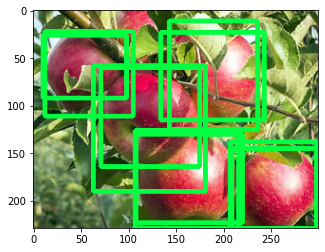

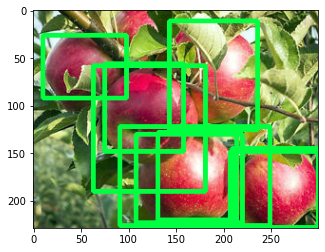

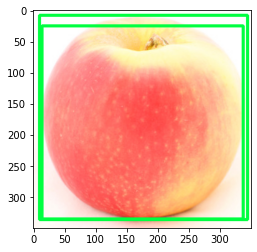

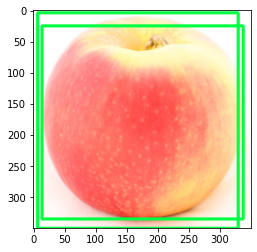

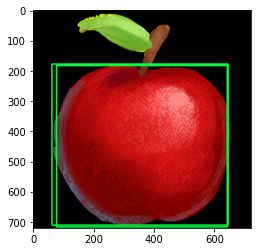

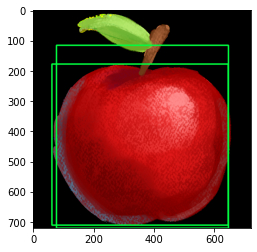

In [43]:
visual(model2, test_dataset, 0.55, 3)

Вывод: Модель делает хорошие предсказания, но без NMS рамки дублируются

### Задание 5.  
  
Реализуйте и примените Non-maximum Suppression. Оцените (визуально и по метрикам), как его использование влияет на качество детекции.   
**NB:** Чтобы продемонстрировать эффективность применения алгоритма, возможно, нужно будет взять достаточно низкий порог конфиденса. 

In [30]:
def nms_pytorch(P : torch.tensor, S: torch.tensor, thresh_iou : float):
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]
    scores = S[:]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()
    keep = []
    while len(order) > 0:
        idx = order[-1]
        keep.append(P[idx])
        order = order[:-1]
        if len(order) == 0:
            break
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
        w = xx2 - xx1
        h = yy2 - yy1
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        rem_areas = torch.index_select(areas, dim = 0, index = order) 
        union = (rem_areas - inter) + areas[idx]
        IoU = inter / union
        mask = IoU < thresh_iou
        order = order[mask]
    
    return keep

In [41]:
def eval_nms(model):
    i=0
    for x in train_dataset:
        sample = copy.deepcopy(x)
        i+=1
        if i < 5:
            continue
        if i == 10:
            break
        model.eval()
        img = sample[0]
        img = to_tensor(img)
        pred = model([img])
        boxes =  nms_pytorch(pred[0]["boxes"], pred[0]["scores"], 0.1)
        create_boxes(sample[0], boxes)

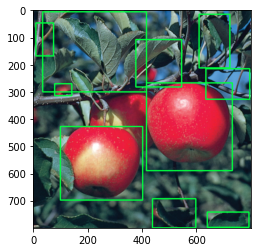

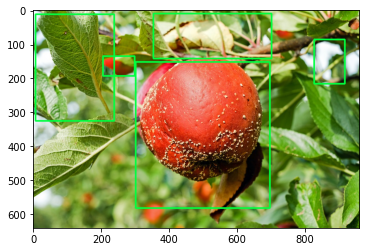

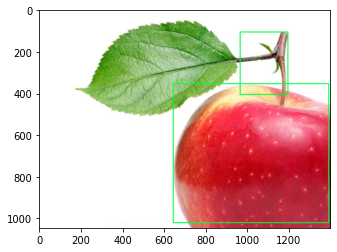

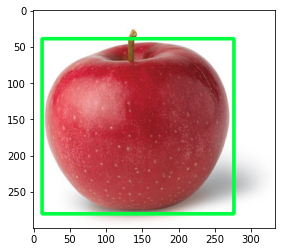

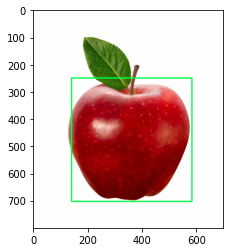

In [42]:
eval_nms(model1)

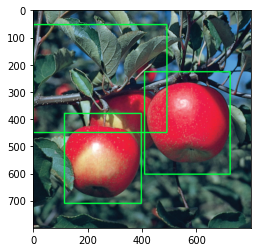

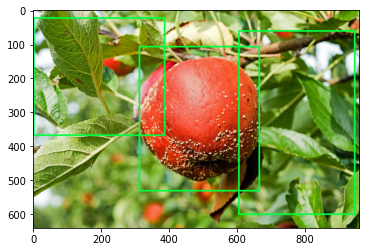

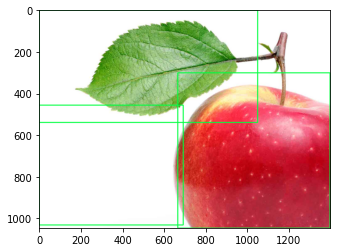

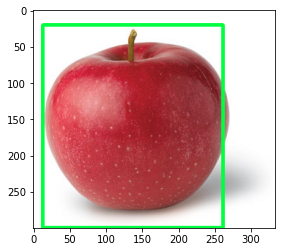

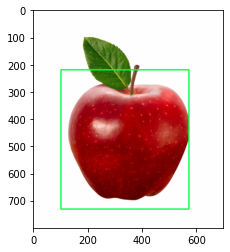

In [44]:
eval_nms(model2)

<br>  
<br>  
  
## Часть 2.  
  
*Вес в общей оценке - 0.4*  
  
Выполните задания 2-5 из предыдущей части для случая 3-х классов (как в изначальном датасете).

In [46]:
model1 = detection.fasterrcnn_resnet50_fpn(pretrained=True)
model2 = detection.fasterrcnn_resnet50_fpn(pretrained=False)

model1.backbone.requires_grad = False
model1.rpn.requires_grad = False

in_features = model2.roi_heads.box_predictor.cls_score.in_features
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4) 

optim1 = torch.optim.SGD(model1.parameters(), lr=1e-2)
optim2 = torch.optim.SGD(model2.parameters(), lr=1e-2)

train_dataset = FruitDataset(train, one_class=False)

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_fn, shuffle=True)

In [47]:
stats1 = fit(model1, 2, optim1, train_dataloader)

torch.save(model1.state_dict(), "model1_part2.pth")

100%|███████████████████████████████████████████████████████████████████| 48/48 [35:35<00:00, 44.48s/it]


epoch number 1, loss is 0.257680752625068


100%|███████████████████████████████████████████████████████████████████| 48/48 [33:17<00:00, 41.61s/it]


epoch number 2, loss is 0.16031485920151076


In [49]:
stats2 = fit(model2, 2, optim2, train_dataloader)

torch.save(model2.state_dict(), "model2_part2.pth")

100%|███████████████████████████████████████████████████████████████████| 48/48 [30:18<00:00, 37.88s/it]


epoch number 1, loss is 0.3389229183085263


100%|███████████████████████████████████████████████████████████████████| 48/48 [30:12<00:00, 37.75s/it]


epoch number 2, loss is 0.3265416768069069


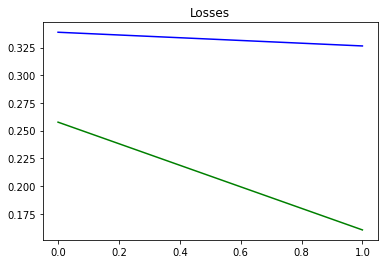

In [51]:
plt.plot(stats1, color='green')
plt.plot(stats2, color='blue')
plt.title("Losses")
plt.show()

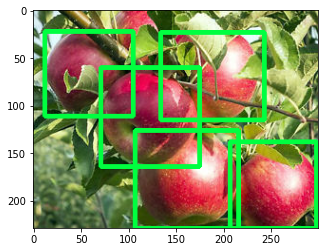

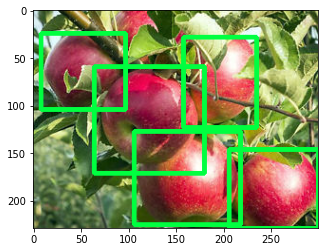

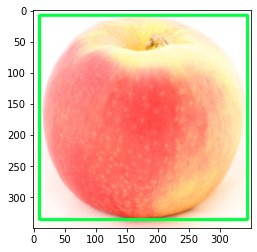

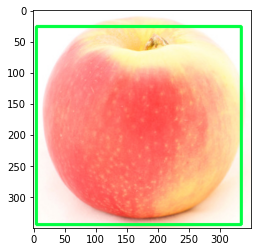

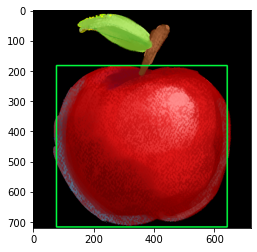

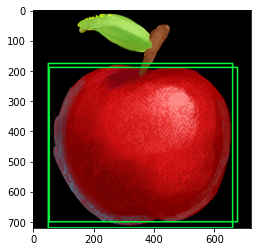

In [52]:
test_dataset = FruitDataset(test, one_class=False)
visual(model1, test_dataset, 0.55, 3)

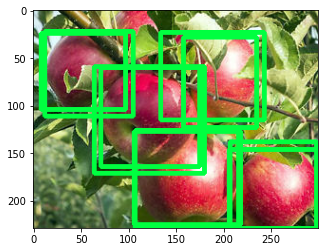

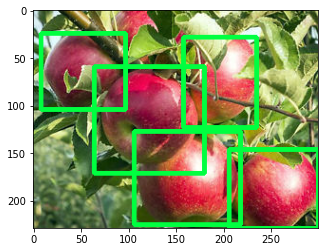

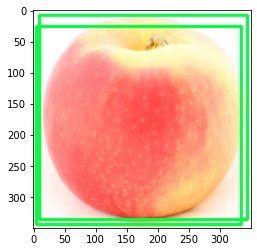

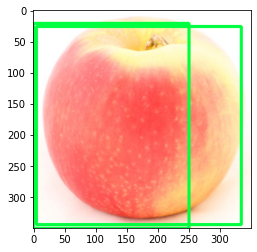

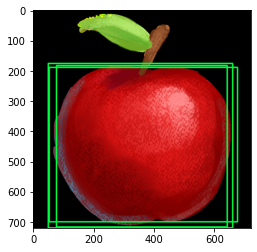

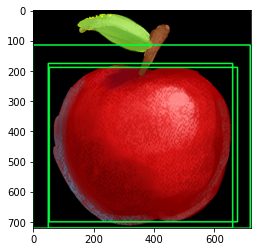

In [53]:
visual(model2, test_dataset, 0.55, 3)

Также опять оценим предсказания с Non Max Supression

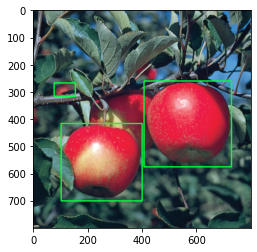

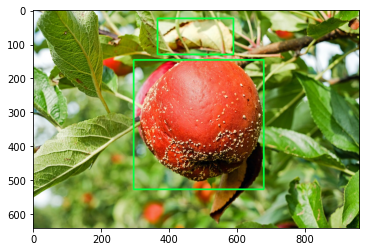

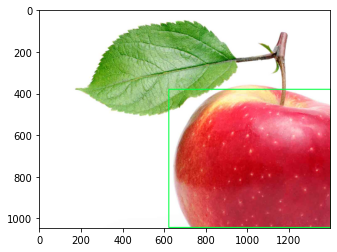

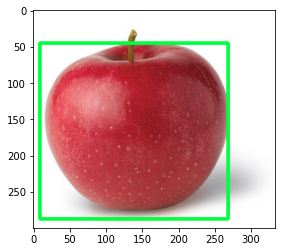

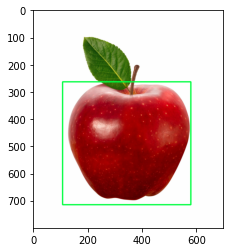

In [54]:
eval_nms(model1)

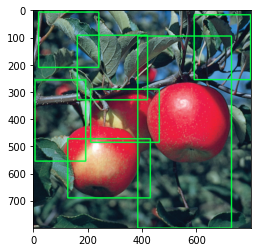

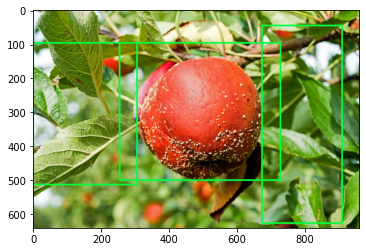

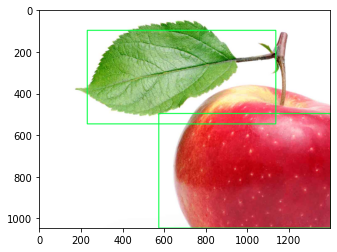

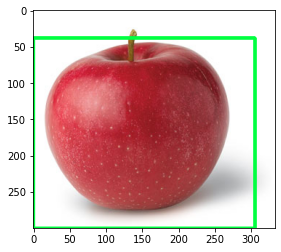

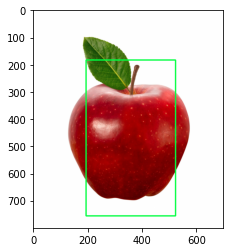

In [55]:
eval_nms(model2)